In [1]:
from collections import Counter, namedtuple
from fbprophet import Prophet
from tqdm import tqdm_notebook as tqdm
from util import (
    calculate_score,
    feature_to_target,
    load_data,
    target_to_feature,
)

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

TRAIN_FILE = './data/train.csv'
TEST_FILE = './data/test.csv'
RANDOM_STATE = 42

In [2]:
train_df, test_df = load_data(TRAIN_FILE, TEST_FILE, None, None)
train_df.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [3]:
def get_sat_data(df, sat_id):
    return df[df.sat_id == sat_id]

def prepare_sat_data_for_prophet(sat_df, value_to_train_on, test_fraction=0.15):
    sat_df = pd.DataFrame(sat_df[['epoch', value_to_train_on]])
    sat_df.columns = ['ds', 'y']
    n_measurements = sat_df.shape[0]
    train_size = int(round((1.0 - test_fraction) * n_measurements))
    sat_train_df = sat_df[:train_size]
    sat_test_df = sat_df[train_size:]
    y_test = sat_test_df.y.values
    sat_test_df = pd.DataFrame(sat_test_df[['ds']])
    sat_test_df.reset_index(drop=True, inplace=True)
    return sat_train_df, sat_test_df, y_test

In [4]:
sat_train = get_sat_data(train_df, 0)
train, test, y_test = prepare_sat_data_for_prophet(sat_train, 'x')

In [18]:
model = Prophet(yearly_seasonality=True)
model.fit(train)
predictions = model.predict(test)

/usr/local/anaconda3/envs/python381/lib/python3.8/site-packages/fbprophet/forecaster.py:400: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  (dates - pd.datetime(1970, 1, 1))


In [19]:
predictions[['ds', 'yhat']]

,ds,yhat
0,2014-01-27 08:13:56.405,7800.009775
1,2014-01-27 09:00:39.405,7845.118512
2,2014-01-27 09:47:22.406,7923.939051
3,2014-01-27 10:34:05.406,8001.297980
4,2014-01-27 11:20:48.407,8027.860630
...,...,...
139,2014-01-31 20:27:33.474,10867.381892
140,2014-01-31 21:14:16.474,10972.995961
141,2014-01-31 22:00:59.475,11112.826532
142,2014-01-31 22:47:42.475,11253.599072


In [23]:
x = sat_train.x.values
x_sim = sat_train.x_sim.values
x_diff = x - x_sim

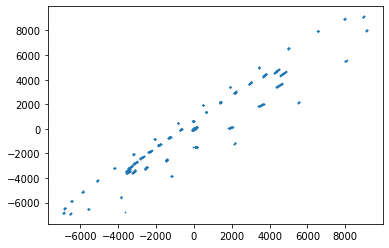

In [28]:
plt.scatter(x_diff[:-1], x_diff[1:], s=0.5)

In [35]:
import statsmodels.tsa.stattools as stat

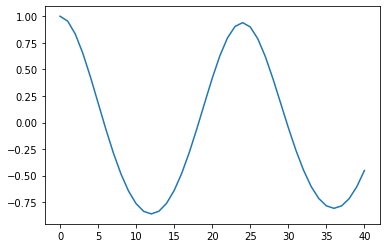

In [37]:
plt.plot(stat.acf(x_diff, fft=False))

In [45]:
result = pd.Timedelta(0)
for i in range(1, 27):
    result += sat_train.epoch[i] - sat_train.epoch[i - 1]
result

Timedelta('0 days 20:14:38.013000')

In [76]:
def calc_distances(sat_train, variables, origin_id):
    points = sat_train[variables].values
    origin = points[origin_id]
    distances = points - origin
    return np.sqrt(np.sum(distances * distances, axis=1))

In [97]:
ORIGIN_ID = 1
distances_sim = calc_distances(sat_train, ['x_sim', 'y_sim', 'z_sim'], ORIGIN_ID)
distances = calc_distances(sat_train, ['x', 'y', 'z'], ORIGIN_ID)

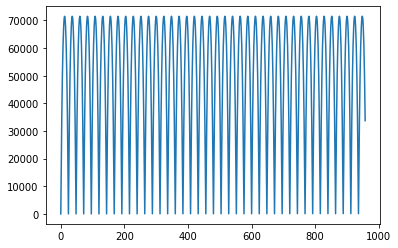

In [81]:
plt.plot(distances_sim)

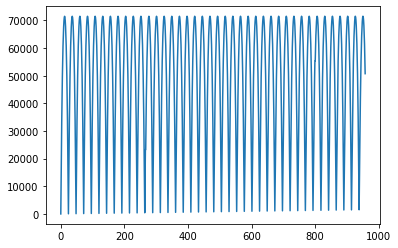

In [82]:
plt.plot(distances)

In [94]:
a = distances[distances < 10000]
a

array([   0.        ,   39.96889874,   79.6837863 ,  118.37955429,
        156.11342103,  192.85747237,  228.56825118,  264.17529292,
        299.63233706,  335.66534278,  372.23495576,  409.616655  ,
        447.70293548,  486.5765916 ,  526.15055591,  565.93014088,
        606.34478603,  646.71955294,  687.34874123,  727.89216388,
        768.22631668,  808.3713113 ,  848.19972438,  887.7922287 ,
        926.73885667,  965.55238079, 1003.71896052, 1041.69414068,
       1079.38116465, 1116.70651775, 1154.14822187, 1191.63332773,
       1229.59575054, 1267.84148141, 1306.82303114, 1346.02816743,
       1385.49285448, 1424.66049002, 1462.75456788, 1499.92748085])

In [96]:
x = sat_train.x.values[distances < 10000]
x[1:] - x[:-1]

array([ 9.47004692,  9.1894442 ,  8.78550841,  8.57699852,  8.58375698,
        8.58879179,  8.97145736,  9.19481311,  9.63673739,  9.87973126,
       10.16494316, 10.30656661, 10.37115704, 10.46451059, 10.28383588,
       10.34358864, 10.1290377 , 10.10795745,  9.987413  ,  9.8996676 ,
        9.87455195,  9.79375913,  9.88723722,  9.76929845,  9.94586715,
        9.90173934, 10.0456729 , 10.16196195, 10.21803399, 10.42924776,
       10.48201502, 10.70232994, 10.65091491, 10.74057425, 10.52443971,
       10.29622426,  9.9874704 ,  9.50173413,  9.31731482])

In [98]:
x = sat_train.x.values[distances < 10000]
x[1:] - x[:-1]

array([2.07643056, 1.75291998, 1.40349764, 1.23331531, 1.32276329,
       1.42669824, 1.83547543, 2.11159244, 2.53329611, 2.77779238,
       3.02201759, 3.14766211, 3.16063431, 3.21757923, 3.03152895,
       3.02412596, 2.81054211, 2.73159386, 2.59511178, 2.4823247 ,
       2.44123935, 2.34546766, 2.43139696, 2.35528931, 2.52487963,
       2.55812082, 2.72707372, 2.91308806, 3.04459999, 3.29852117,
       3.39648748, 3.61171004, 3.5614056 , 3.56839677, 3.31114504,
       2.98923102, 2.64803662, 2.19709189, 2.05045845])

In [101]:
sat_train.x.values[:3]

array([ -8855.8238626 , -10567.67238391, -10578.68404349])

In [102]:
sat_train.Vx.values[:3]

array([-0.90830256, -0.30259012,  0.27743545])

In [103]:
sat_train.epoch[:3]

0   2014-01-01 00:00:00.000
1   2014-01-01 00:46:43.000
2   2014-01-01 01:33:26.001
Name: epoch, dtype: datetime64[ns]

In [106]:
(1400 * -0.90830256 + 1403 * -0.30259012) + -8855.8238626

-10551.98138496

In [92]:
b = distances_sim[distances_sim < 10000]
b

array([  0.        ,   2.06955011,   4.36278554,   7.00828123,
        10.09415631,  13.65368972,  17.64412297,  21.9398598 ,
        26.34748478,  30.63902412,  34.59318669,  38.03044995,
        40.83642745,  42.97270523,  44.47355777,  45.43339685,
        45.99022147,  46.3058139 ,  46.54693228,  46.87079905,
        47.41378704,  48.28542951,  49.56837839,  51.31979985,
        53.57221071,  56.33202684,  59.57282655,  63.2269491 ,
        67.18163176,  71.28263255,  75.34974945,  79.20501023,
        82.7063713 ,  85.78030615,  88.44538202,  90.81632794,
        93.0859442 ,  95.48827838,  98.24901182, 101.53674401])